<a href="https://colab.research.google.com/github/GulshanSharma1981/PythonFirst/blob/main/BainTumor_CV_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
%cd gdrive/My Drive/2d

/content/gdrive/My Drive/2d


### Downloading the dataset from figshare.com/articles/brain_tumor_dataset/1512427

In [6]:
!wget https://ndownloader.figshare.com/articles/1512427/versions/5

--2023-10-08 18:29:44--  https://ndownloader.figshare.com/articles/1512427/versions/5
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 52.16.102.173, 54.217.124.219, 2a05:d018:1f4:d003:1c8b:1823:acce:812, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|52.16.102.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: ‘5’

5                   100%[===================>] 838.76M  43.9MB/s    in 20s     

2023-10-08 18:30:04 (42.9 MB/s) - ‘5’ saved [879501695/879501695]



In [7]:
!unzip 5 && rm 5

Archive:  5
 extracting: brainTumorDataPublic_1-766.zip  
 extracting: brainTumorDataPublic_1533-2298.zip  
 extracting: brainTumorDataPublic_767-1532.zip  
 extracting: brainTumorDataPublic_2299-3064.zip  
 extracting: cvind.mat               
 extracting: README.txt              


In [8]:
!cat brainTumorDataPublic_* > brainTumorDataPublic_temp.zip
!zip -FF brainTumorDataPublic_temp.zip --out data.zip

Fix archive (-FF) - salvage what can
 Found end record (EOCDR) - says expect single disk archive
Scanning for entries...
 copying: 1533.mat  (339637 bytes)
 copying: 1534.mat  (340418 bytes)
 copying: 1535.mat  (342222 bytes)
 copying: 1536.mat  (342920 bytes)
 copying: 1537.mat  (343484 bytes)
 copying: 1538.mat  (323526 bytes)
 copying: 1539.mat  (326770 bytes)
 copying: 1540.mat  (328641 bytes)
 copying: 1541.mat  (331088 bytes)
 copying: 1542.mat  (333075 bytes)
 copying: 1543.mat  (335548 bytes)
 copying: 1544.mat  (337196 bytes)
 copying: 1545.mat  (265792 bytes)
 copying: 1546.mat  (266357 bytes)
 copying: 1547.mat  (267792 bytes)
 copying: 1548.mat  (269198 bytes)
 copying: 1549.mat  (267728 bytes)
 copying: 1550.mat  (265932 bytes)
 copying: 1551.mat  (264956 bytes)
 copying: 1552.mat  (262235 bytes)
 copying: 1553.mat  (262966 bytes)
 copying: 1554.mat  (263969 bytes)
 copying: 1555.mat  (264622 bytes)
 copying: 1556.mat  (264585 bytes)
 copying: 1557.mat  (347465 bytes)
 cop

In [9]:
!rm brainTumorDataPublic_*

In [10]:
!unzip data.zip -d data && rm data.zip

Archive:  data.zip
  inflating: data/1533.mat           
  inflating: data/1534.mat           
  inflating: data/1535.mat           
  inflating: data/1536.mat           
  inflating: data/1537.mat           
  inflating: data/1538.mat           
  inflating: data/1539.mat           
  inflating: data/1540.mat           
  inflating: data/1541.mat           
  inflating: data/1542.mat           
  inflating: data/1543.mat           
  inflating: data/1544.mat           
  inflating: data/1545.mat           
  inflating: data/1546.mat           
  inflating: data/1547.mat           
  inflating: data/1548.mat           
  inflating: data/1549.mat           
  inflating: data/1550.mat           
  inflating: data/1551.mat           
  inflating: data/1552.mat           
  inflating: data/1553.mat           
  inflating: data/1554.mat           
  inflating: data/1555.mat           
  inflating: data/1556.mat           
  inflating: data/1557.mat           
  inflating: data/1558.mat     

In [11]:
!ls data | wc -l

3064


In [12]:
!pip install hdf5storage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 1.2 MB/s eta 0:00:00


## Creating images, labels and masks numpy arrays

In [13]:
import os
import argparse
import sys
import numpy as np
import hdf5storage
import cv2
import matplotlib.pyplot as plt

class NoDataFound(Exception):
    pass


def dir_path(path):
    """Check the path and the existence of a data directory"""
    # replace '\' in path for Windows users
    path = path.replace('\\', '/')
    data_path = os.path.join(path, 'data').replace('\\', '/')

    if os.path.isdir(data_path):
        return path
    elif os.path.isdir(path):
        raise NoDataFound('Could not find a "data" folder inside directory. {} does not exist.'
                          .format(data_path))
    else:
        raise NotADirectoryError(path)

path='/content/gdrive/My Drive/2d/'
parser = argparse.ArgumentParser()
parser.add_argument('path', help='path to the brain_tumor_dataset directory', type=dir_path)
parser.add_argument('--image-dimension', '-d', default=512, help='dimension of the image', type=int)
args = parser.parse_args(args=[path])

labels = []
images = []
masks = []

data_dir = os.path.join(args.path, 'data').replace('\\', '/')
files = os.listdir(data_dir)
for i, file in enumerate(files, start=1):
    if i % 10 == 0:
        # print the percentage of images loaded
        sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                         .format(i, len(files), i / float(len(files)) * 100))
        sys.stdout.flush()

    # load matlab file with hdf5storage as scipy.io.loadmat does not support v7.3 files
    mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0]

    # resize image and mask to a unique size
    image = cv2.resize(mat_file[2], dsize=(args.image_dimension, args.image_dimension),
                       interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mat_file[4].astype('uint8'), dsize=(args.image_dimension, args.image_dimension),
                      interpolation=cv2.INTER_CUBIC)

    labels.append(int(mat_file[0]))
    images.append(image)
    masks.append(mask.astype(bool))

sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                 .format(i, len(files), i / float(len(files)) * 100))
sys.stdout.flush()

labels = np.array(labels)
images = np.array(images)
masks = np.array(masks)

print('\nlabels:', labels.shape)
print('images:', images.shape)
print('masks:', masks.shape)

np.save(os.path.join(args.path, 'labels.npy'), labels)
np.save(os.path.join(args.path, 'images.npy'), images)
np.save(os.path.join(args.path, 'masks.npy'), masks)

print('labels.npy, images.npy, masks.npy saved in', args.path)

[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy saved in /content/gdrive/My Drive/2d/


In [14]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

In [15]:
labels = np.load('labels.npy')
images = np.load('images.npy')
masks = np.load('masks.npy')

print(labels.shape)
print(images.shape)
print(masks.shape)

(3064,)
(3064, 512, 512)
(3064, 512, 512)


# Data Visuallisation

number of meningioma (1): 708
number of glioma (2): 1426
number of pituitary tumor (3): 930


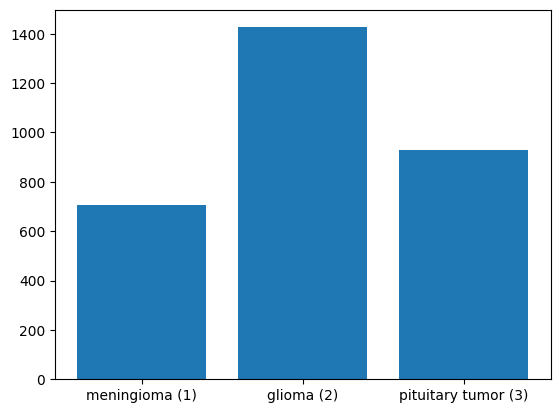

In [16]:
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts,
        tick_label=['meningioma (1)', 'glioma (2)', 'pituitary tumor (3)'])

for i, idx in enumerate(classes):
    print('number of {}: {}'.format(integer_to_class[str(idx)], counts[i]))

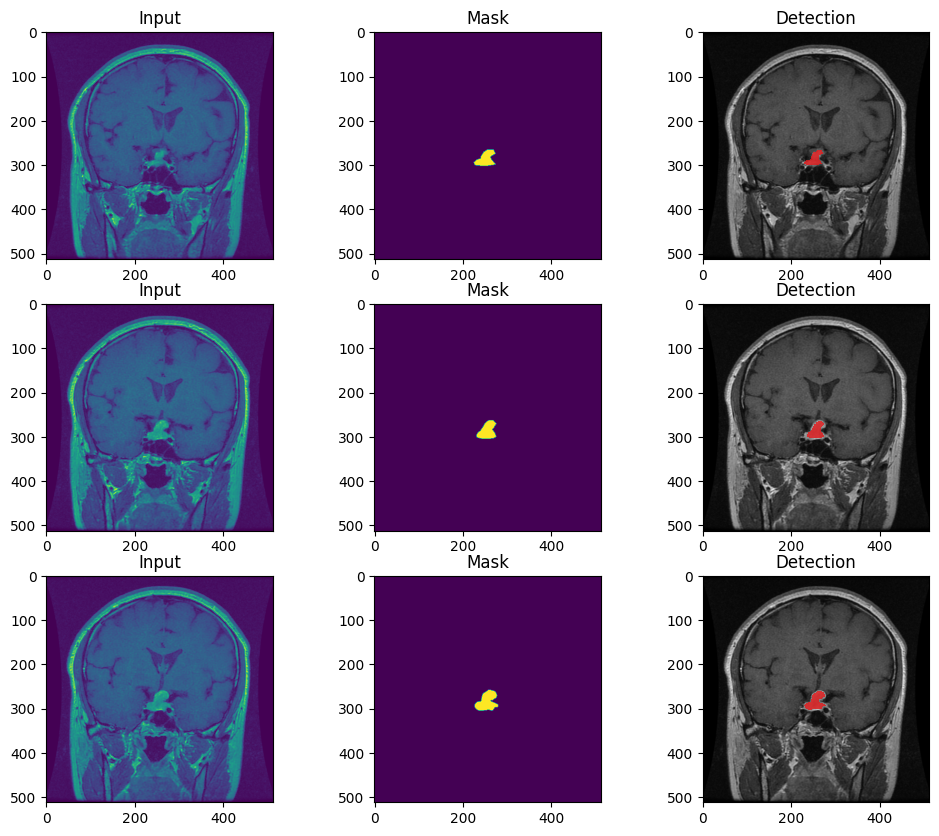

In [17]:
plt.figure(figsize=(12, 10))

plt.subplot(3,3,1)
plt.title('Input')
plt.imshow(images[0,:])

plt.subplot(3,3,2)
plt.title('Mask')
plt.imshow(masks[0,:])

plt.subplot(3,3,3)
plt.title('Detection')
plt.imshow(images[0,:],cmap='gray')
mask = np.ma.masked_where(masks[0] == False, masks[0])
plt.imshow(mask, alpha=0.8, cmap='Set1')

plt.subplot(3,3,4)
plt.title('Input')
plt.imshow(images[1,:])

plt.subplot(3,3,5)
plt.title('Mask')
plt.imshow(masks[1,:])

plt.subplot(3,3,6)
plt.title('Detection')
plt.imshow(images[1,:],cmap='gray')
mask = np.ma.masked_where(masks[1] == False, masks[1])
plt.imshow(mask, alpha=0.8, cmap='Set1')

plt.subplot(3,3,7)
plt.title('Input')
plt.imshow(images[2,:])

plt.subplot(3,3,8)
plt.title('Mask')
plt.imshow(masks[2,:])

plt.subplot(3,3,9)
plt.title('Detection')
plt.imshow(images[2,:],cmap='gray')
mask = np.ma.masked_where(masks[2] == False, masks[2])
plt.imshow(mask, alpha=0.8, cmap='Set1')


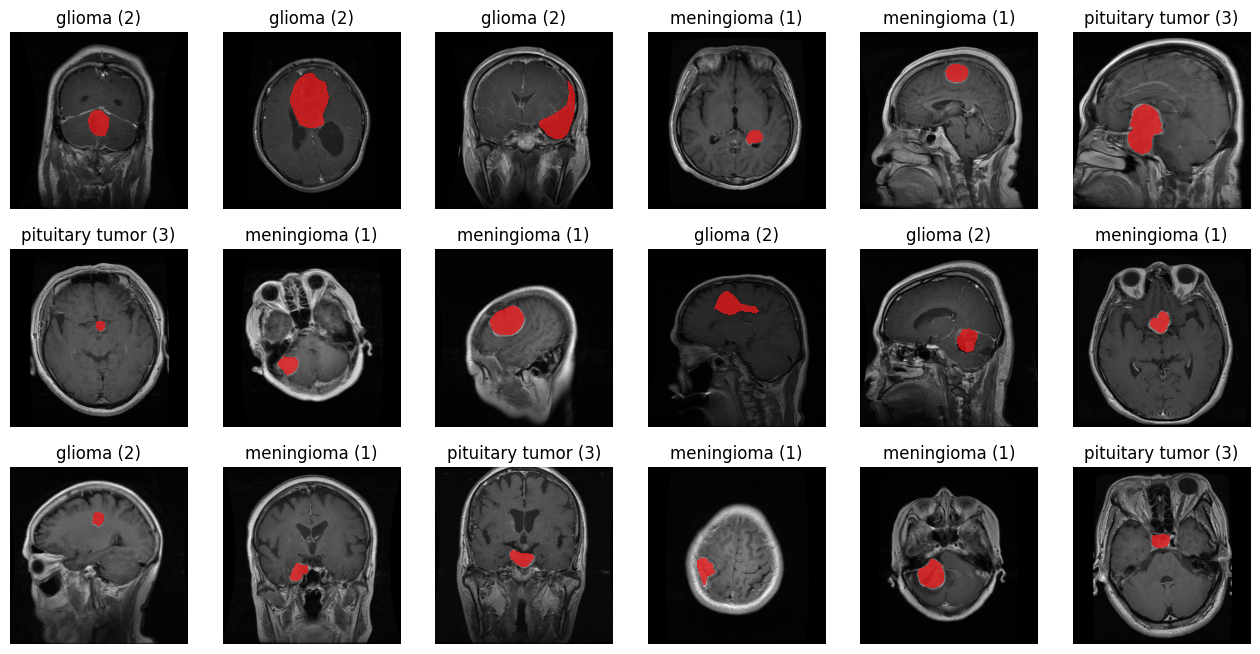

In [18]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images[idx], cmap='gray')

    # set black pixel as transparent for the mask
    mask = np.ma.masked_where(masks[idx] == False, masks[idx])
    plt.imshow(mask, alpha=0.8, cmap='Set1')

    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

### Cropping the image

In [19]:
def get_bounding_box(mask):
    """
    Return the bounding box of a mask image.
    """
    xmin, ymin, xmax, ymax = 0, 0, 0, 0

    for row in range(mask.shape[0]):
        if mask[row, :].max() != 0:
            ymin = row
            break

    for row in range(mask.shape[0] - 1, -1, -1):
        if mask[row, :].max() != 0:
            ymax = row
            break

    for col in range(mask.shape[1]):
        if mask[:, col].max() != 0:
            xmin = col
            break

    for col in range(mask.shape[1] - 1, -1, -1):
        if mask[:, col].max() != 0:
            xmax = col
            break

    return xmin, ymin, xmax, ymax


def crop_to_bbox(image, bbox, crop_margin=10):
    """
    Crop an image to the bounding by forcing a squared image as output.
    """
    x1, y1, x2, y2 =  bbox

    # force a squared image
    max_width_height = np.maximum(y2 - y1, x2 - x1)
    y2 = y1 + max_width_height
    x2 = x1 + max_width_height

    # in case coordinates are out of image boundaries
    y1 = np.maximum(y1 - crop_margin, 0)
    y2 = np.minimum(y2 + crop_margin, image.shape[0])
    x1 = np.maximum(x1 - crop_margin, 0)
    x2 = np.minimum(x2 + crop_margin, image.shape[1])

    return image[y1:y2, x1:x2]

In [20]:
from IPython.display import display, clear_output

dim_cropped_image = 224

images_cropped = []

for i in range(images.shape[0]):
    if i % 10 == 0:
        # print the pecentage of images processed
        clear_output(wait=True)
        display('[{}/{}] images processed: {:.1f} %'
                .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))

    bbox = get_bounding_box(masks[i])
    image = crop_to_bbox(images[i], bbox, 20)
    image = cv2.resize(image, dsize=(dim_cropped_image, dim_cropped_image),
                       interpolation=cv2.INTER_CUBIC)
    images_cropped.append(image)

clear_output(wait=True)
display('[{}/{}] images processed: {:.1f} %'
        .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))

'[3064/3064] images processed: 100.0 %'

In [21]:
images_cropped = np.array(images_cropped)

print(images_cropped.shape)

(3064, 224, 224)


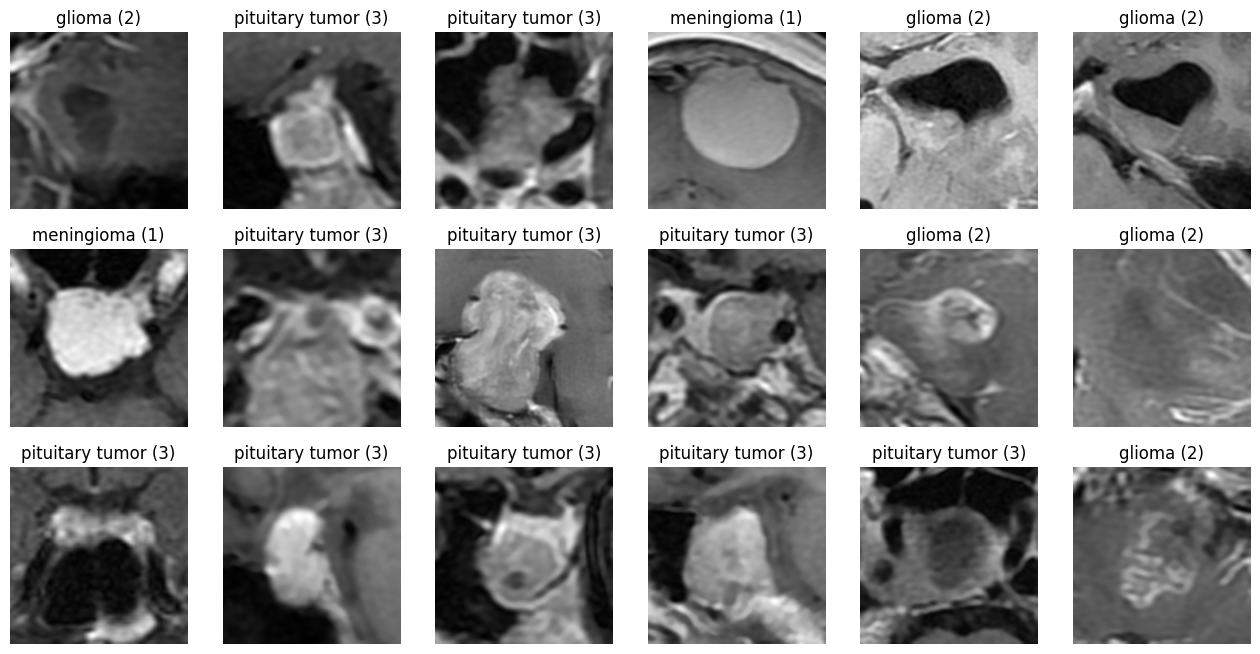

In [22]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images_cropped[idx],cmap='gray')

    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

## Normalizing the images

In [23]:
import os
import argparse
import sys
import numpy as np
import hdf5storage
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

In [24]:
labels = np.load('labels.npy')
images = np.load('images.npy')
masks = np.load('masks.npy')

In [25]:
images = images[..., np.newaxis]

In [26]:
masks = masks[..., np.newaxis]

In [27]:
for i in range(images.shape[0]):
  images[i,:, :] = (images[i,:, :] - np.min(images[i,:, :]))/ (np.max(images[i,:, :])-np.min(images[i,:, :]) )

### Evaluation Metrics

In [28]:
from keras.losses import binary_crossentropy
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

Splitting the dataset into Training, Validation and Test Set

In [30]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(images,masks,test_size=0.2,train_size=0.8,random_state=1)
images_test, images_cv, masks_test, masks_cv = train_test_split(images_test,masks_test,test_size = 0.5,train_size =0.5,random_state=1)

In [31]:
print ("number of training examples = " + str(images_train.shape[0]))
print ("number of development examples = " + str(images_cv.shape[0]))
print ("number of test examples = " + str(images_test.shape[0]))
print ("Images_train shape: " + str(images_train.shape))
print ("Masks_train shape: " + str(masks_train.shape))
print ("Images_val (dev) shape: " + str(images_cv.shape))
print ("Masks_val (dev) shape: " + str(masks_cv.shape))
print ("Images_test shape: " + str(images_test.shape))
print ("Masks_test shape: " + str(masks_test.shape))

number of training examples = 2451
number of development examples = 307
number of test examples = 306
Images_train shape: (2451, 512, 512, 1)
Masks_train shape: (2451, 512, 512, 1)
Images_val (dev) shape: (307, 512, 512, 1)
Masks_val (dev) shape: (307, 512, 512, 1)
Images_test shape: (306, 512, 512, 1)
Masks_test shape: (306, 512, 512, 1)


## UNET Model

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
import random as r
import math
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as keras
import os
import argparse
import sys
import cv2
import skimage.transform as trans

In [36]:
def unet(input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2DTranspose(512,2,strides=(2,2),padding='same')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(256,2,strides=(2,2),padding='same')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(128,2,strides=(2,2),padding='same')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2DTranspose(64,2,strides=(2,2),padding='same')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss='binary_crossentropy', metrics=[dice_coef])

    model.summary()
    return model

In [37]:
filepath="cnn-parameters-improvement-{epoch:02d}-{dice_coef:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor=[dice_coef], verbose=1, save_best_only=True, mode='max'))
model=unet()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 512, 512, 64)         640       ['input_2[0][0]']             
                                                                                                  
 conv2d_21 (Conv2D)          (None, 512, 512, 64)         36928     ['conv2d_20[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 256, 256, 64)         0         ['conv2d_21[0][0]']           
 g2D)                                                                                       